### ABOUT THE DATASET
I Found my dataset on kaggle at this link: https://www.kaggle.com/datasets/akshaydattatraykhare/data-for-admission-in-the-university.
It is about data required to take admission in the university for higher studies.


![IMAGE3](IMAGE3.png)


This dataset includes various information like GRE score, TOEFL score, university rating, SOP (Statement of Purpose), LOR (Letter of Recommendation), CGPA, research and chance of admit. In this dataset, 400 entries are included.

* GRE Scores ( out of 340 )
* TOEFL Scores ( out of 120 )
* University Rating ( out of 5 )
* Statement of Purpose (SOP) and Letter of Recommendation (LOR) Strength ( out of 5 )
* Undergraduate GPA ( out of 10 )
* Research Experience ( either 0 or 1 )
* Chance of Admit ( ranging from 0 to 1 ).

### GOALS OF MY ANALYSIS:

* Understand what are the scores of the students which have the probability to be admitted  greater than  the mean. 
* Understand what are the caratteristics of who is recognized as outlier.
* Understand which is the best cluster algorithm  and the optimal number of clusters.
* Understand which is the best cluster algorithm in terms of misclassifications.
* Understand if the dummy variable 'Research' has real impact on the probability of Admission.


In [87]:
library('ggplot2')
library('factoextra')
library('cluster')
library('clustertend')
library('NbClust')
library('clValid')
library('mclust')
library('pdfCluster')
library('fpc')
library('psych')

In [4]:
setwd("~/Desktop/DATA ANALYSIS PROJECT/code")
DATA=read.csv('~/Desktop/DATA ANALYSIS PROJECT/data/adm_data.csv')

We will use this function to obtain figures of less size!

In [5]:
fig <- function(width, heigth){
     options(repr.plot.width = width, repr.plot.height = heigth)
}

In [6]:
DF = DATA[,c(-1,-4,-9)]
DF$Research = as.factor(DF[,6])

str(DF)

'data.frame':	400 obs. of  6 variables:
 $ GRE.Score  : int  337 324 316 322 314 330 321 308 302 323 ...
 $ TOEFL.Score: int  118 107 104 110 103 115 109 101 102 108 ...
 $ SOP        : num  4.5 4 3 3.5 2 4.5 3 3 2 3.5 ...
 $ LOR        : num  4.5 4.5 3.5 2.5 3 3 4 4 1.5 3 ...
 $ CGPA       : num  9.65 8.87 8 8.67 8.21 9.34 8.2 7.9 8 8.6 ...
 $ Research   : Factor w/ 2 levels "0","1": 2 2 2 2 1 2 2 1 1 1 ...


To start with our analysis, we have to exclude the two outcomes variables: chance of the admission And university ranting. For the clasterizzation process We will not use those variables, but we will use the first one when we talk about external information.

### ASSESSING CLUSTER TENDENCY
Before applying any clustering algorithm, the first step is to evaluate if there is a cluster strucure in our dataset. To do this we have to compare the observed situation with the theoretichal situation, where there aren't clusters. This one must be generated from a random uniform distrubuition.

In [7]:
df=DF[,-6]
df_sc= scale(df)

In [8]:
random_df = apply(df,2,function(x){runif(length(x),min(x),max(x))})
random_df = as.data.frame(random_df)
random_df = scale(random_df)

To evaluate if there is a cluster structure, we can can colour the two graphics using the outcome variable:
* __admitted__: is a new dummy variable which cames from chance of admission. We want to assign TRUE to people which have a chance of admission greater than the mean to be Admitted,otherwise we will assign FALSE.

In [9]:
admitted=factor(replace(DATA$Chance.of.Admit,DATA$Chance.of.Admit<=0.73,0)
                    & replace(DATA$Chance.of.Admit,DATA$Chance.of.Admit>0.73,1))

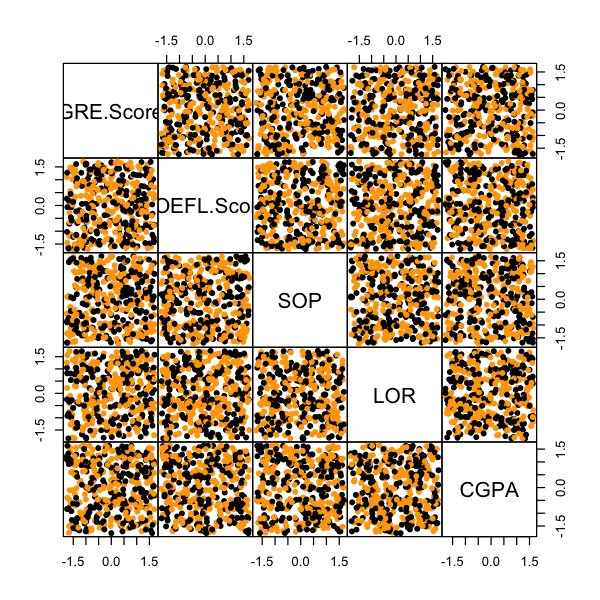

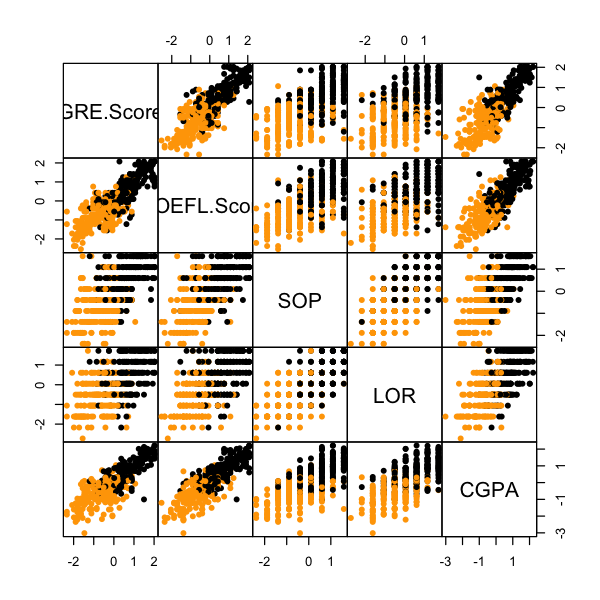

In [10]:
fig(5,5)
pairs(random_df,gap=0,pch=16,col=c('orange','black')[admitted])
pairs(df_sc,gap=0,pch=16,col=c('orange','black')[admitted])

According to this plots, we can say that probably in our dataset We have a cluster structures. In fact when we colour our data using admitted, we observe two partitions. Instead for data generated by a random uniform distribution we are not able to distinguish any cluster structures.

#### Other methods for assessing clustering tendency

* _Hopkins Statistic_: The Hopkins statistic H is a measure of clustering tendency taking values in [0, 1]. This one evaluate if our data are generated by a random uniform distribution. Lower is the value in that range higher is the probabilty of a cluster structures.

* _VAT Algorithm_: The VAT Algorithm is a visual method that evaluate the cluster tendency by counting the number of square shaped red blocks along the diagonal in a VAT image. 


In [11]:
set.seed(123)
hopkins(random_df,n=nrow(random_df)-1)
hopkins(df_sc,n=nrow(df_sc)-1)

Warning message:
“Package `clustertend` is deprecated.  Use package `hopkins` instead.”


$H
[1] 0.5016036

Warning message:
“Package `clustertend` is deprecated.  Use package `hopkins` instead.”


$H
[1] 0.2466646

We can observe that our dataset has a very low Hopkins statistic index __0.25__, it indicates a good propensity to clustering.
While the random uniform generated dataset has a H value of __0.50__, so it indicates no meaningful clusters.

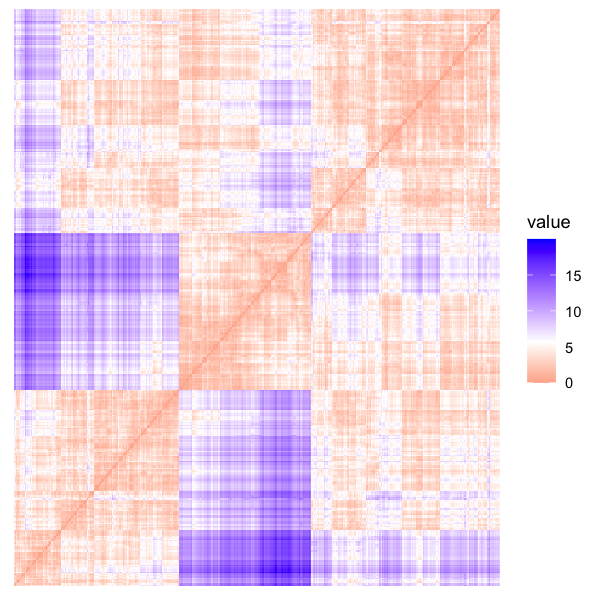

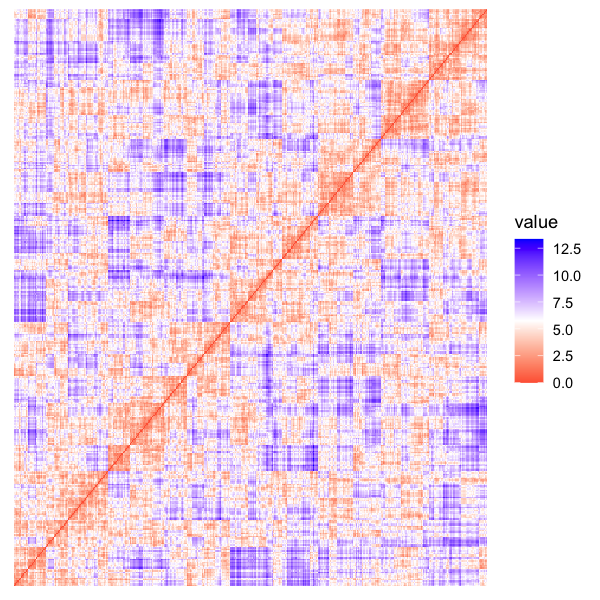

In [17]:
fviz_dist(dist(df_sc,method = "manhattan"),show_labels=FALSE)
fviz_dist(dist(random_df,method = "manhattan"),show_labels=FALSE)

if we compute the VAT Algorithm using the 'manhattan distance' seems to be at least three clusters. Instead when we perform the VAT Algorithm on the theoretichal data we don't observe any square shaped blocks

### Determining the Optimal Number of Clusters
Unfortunately, there is no definitive solution to this issue, because the optimal number of clusters is somehow subjective and depends on the clustering method used.

__ELBOW METHOD__

We should choose K so that adding another cluster doesn’t improve WSS so much.

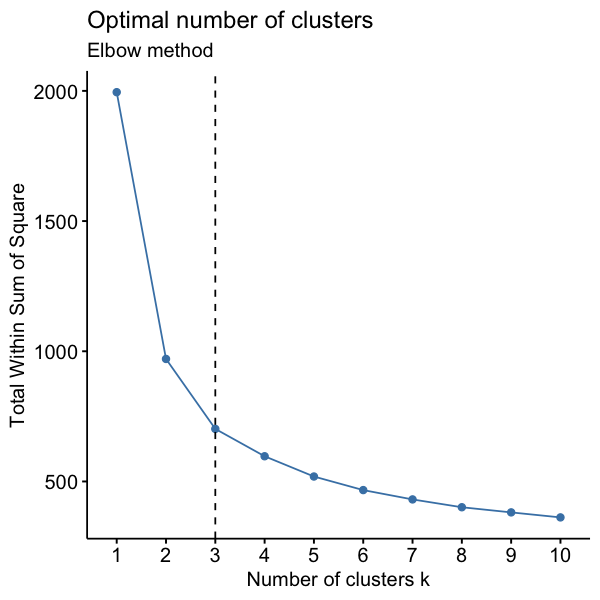

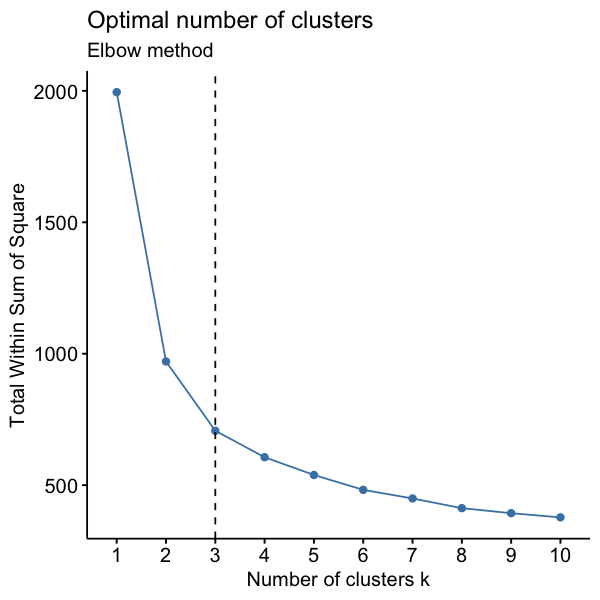

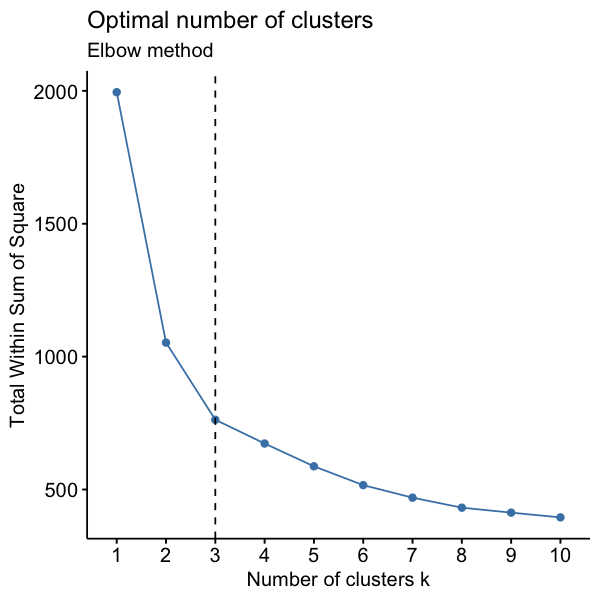

In [19]:
fviz_nbclust(df_sc,kmeans, iter.max = 100,nstart=1000,method='wss')+
  geom_vline(xintercept= 3, linetype=2)+
  labs(subtitle = 'Elbow method')

fviz_nbclust(df_sc,pam,nstart=100,method='wss')+
  geom_vline(xintercept= 3, linetype=2)+
  labs(subtitle = 'Elbow method')

fviz_nbclust(df_sc,hcut,method='wss')+
  geom_vline(xintercept= 3, linetype=2)+
  labs(subtitle = 'Elbow method')

It looks like that the elbow is on K=3

__SILHOUETTE METHOD__

The optimal number of clusters K is the one that maximizes the average silhouette over a range of possible values for K

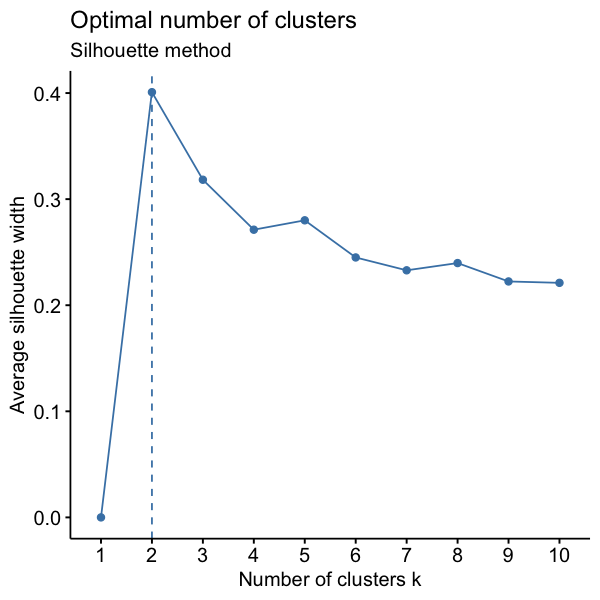

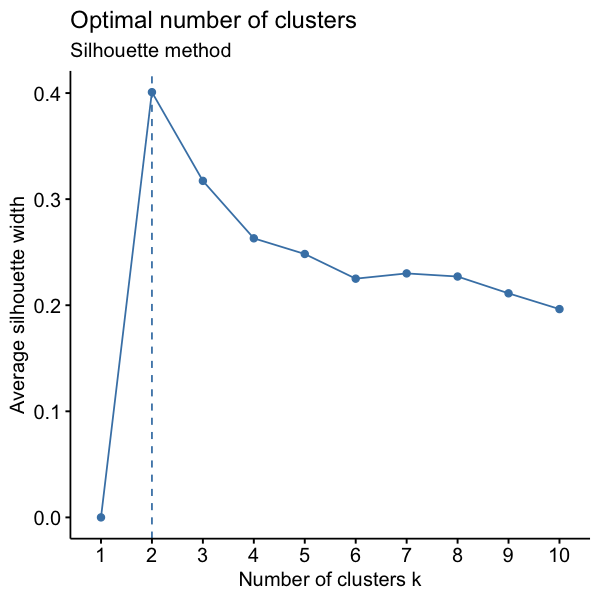

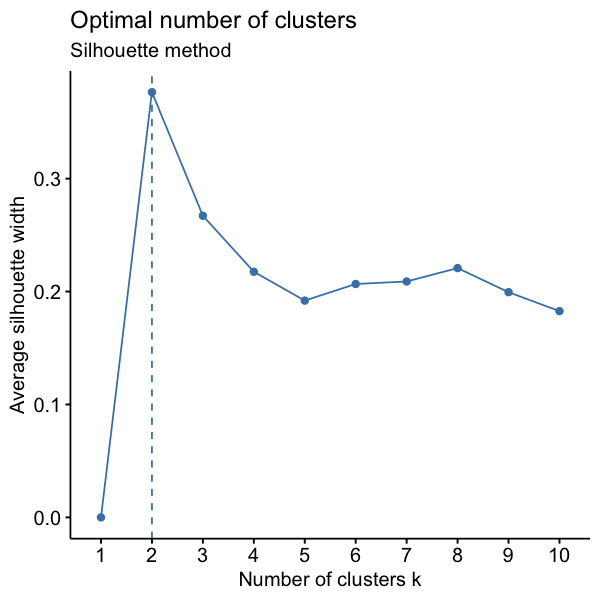

In [20]:
fviz_nbclust(df_sc,kmeans,iter.max = 100,nstart=100,method='silhouette')+
  labs(subtitle = 'Silhouette method')

fviz_nbclust(df_sc,pam,nstart=100,method='silhouette')+
  labs(subtitle = 'Silhouette method')

fviz_nbclust(df_sc,hcut,method='silhouette')+
  labs(subtitle = 'Silhouette method')

The Silhouette method suggests us to take K=2 as the optimal number of clusters

__GAP STATISTIC__

Gap statistic tries to formalize the heuristic elbow method. For each K , the idea is to compare the within-cluster dispersion (WSS) to its expectation under an appropriate null reference distribution, i.e. a distribution with no obvious clustering (typically a uniform distribution). _The estimate of the optimal number of clusters will be the value that maximizes the gap statistic_.

The higher the difference between the WSS and its expectation under the null reference distribution, the higher the value of the GAP statistic, better is the partition obtained.

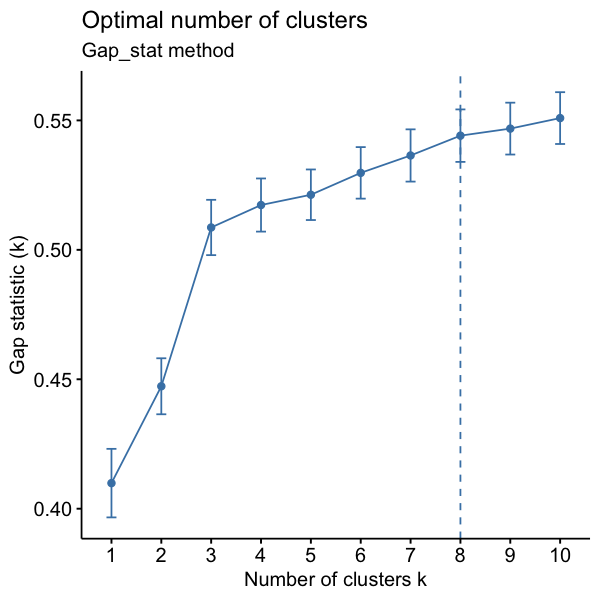

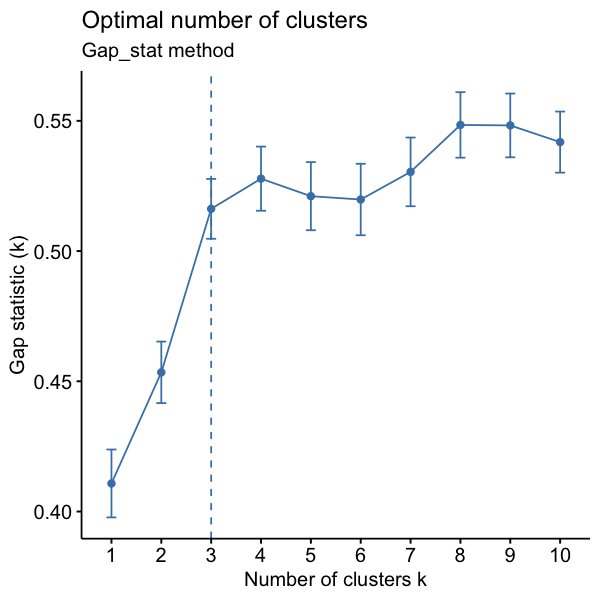

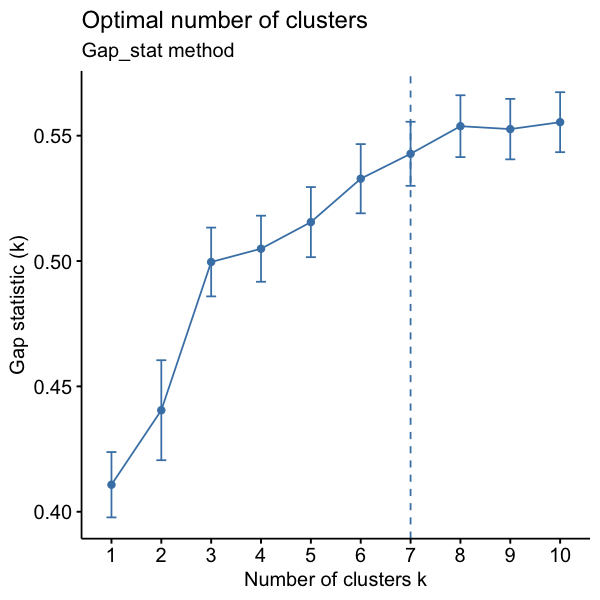

In [22]:
fviz_nbclust(df_sc,kmeans, iter.max = 100,nstart= 100, method='gap_stat',nboot = 500)+
labs(subtitle = 'Gap_stat method')

fviz_nbclust(df_sc,pam, method='gap_stat',nboot = 500)+
  labs(subtitle = 'Gap_stat method')

fviz_nbclust(df_sc,hcut, method='gap_stat',nboot = 500)+
labs(subtitle = 'Gap_stat method')

To summarize:

* According to the elbow method we have to choose 3 clusters
* According to the silhouette method we have to choose 2 clusters
* According to the Gap Statistic we have to choose 3,7 and 8 clusters depends on the method used('pam',hcut','kmeans',)



### Measures for comparing clustering algorithms

The __clValid__ package compares clustering algorithms using two cluster validation measures:
* __Internal measures__, which use intrinsic information in the data to evaluate the quality of the clustering, without reference to external information. Internal measures include the _Connectivity_ (a positive index that should be minimized), _the silhouette coefficient_ and the _Dunn index_(that should be maximized)

* __Stability measures__, a special version of internal measures, which evaluate the stability of a clustering result by comparing it with the clusters obtained after each column (variable) is removed, one at a time.

We can use internal measures also to detect the optimal number of clusters

__Internal Cluster Validation__

In [23]:
clust.methods = c("hierarchical","kmeans","pam")
internal = clValid(df_sc,nClust = 2:6,clMethods = clust.methods, validation = c("internal"))
summary(internal)

Warning message in clValid(df_sc, nClust = 2:6, clMethods = clust.methods, validation = c("internal")):
“rownames for data not specified, using 1:nrow(data)”



Clustering Methods:
 hierarchical kmeans pam 

Cluster sizes:
 2 3 4 5 6 

Validation Measures:
                                  2        3        4        5        6
                                                                       
hierarchical Connectivity   46.9258  49.8548  70.4333  76.9238  76.9238
             Dunn            0.0569   0.0569   0.0762   0.0762   0.0762
             Silhouette      0.3763   0.2972   0.2835   0.2530   0.2107
kmeans       Connectivity   47.5520  76.6933 141.8925 138.6556 171.6488
             Dunn            0.0684   0.0543   0.0473   0.0913   0.0657
             Silhouette      0.4009   0.3183   0.2684   0.2805   0.2450
pam          Connectivity   56.9952  78.5393 126.8266 140.8187 187.2925
             Dunn            0.0496   0.0575   0.0612   0.0751   0.0883
             Silhouette      0.4008   0.3172   0.2631   0.2491   0.2196

Optimal Scores:

             Score   Method       Clusters
Connectivity 46.9258 hierarchical 2       
Dunn   

According to __Internal Measures__, it can be seen that the best algorithm to obtain partitions is 'K-MEANS' and the optimal number of cluster is two.
In particular:
* Connectivity is minimized when we use Hc methods with 2 clusters.
* Silhouette is maximized when we use Kmeans method with 5 clusters.
* Dunn Index is maximized when we use Kmeans method with 2 clusters.


In [24]:
stability = clValid(df_sc,nClust = 2:6,clMethods = clust.methods, validation = "stability")
summary(stability)

Warning message in clValid(df_sc, nClust = 2:6, clMethods = clust.methods, validation = "stability"):
“rownames for data not specified, using 1:nrow(data)”



Clustering Methods:
 hierarchical kmeans pam 

Cluster sizes:
 2 3 4 5 6 

Validation Measures:
                       2      3      4      5      6
                                                    
hierarchical APN  0.2187 0.3339 0.2980 0.3051 0.3601
             AD   2.4177 2.3031 2.1206 2.0743 2.0410
             ADM  1.0248 1.0170 0.8918 0.8701 0.9008
             FOM  0.8037 0.7309 0.7064 0.6931 0.6777
kmeans       APN  0.0792 0.1156 0.2299 0.2468 0.3319
             AD   2.1196 1.8331 1.7747 1.6561 1.6222
             ADM  0.2438 0.2422 0.4874 0.4569 0.6033
             FOM  0.7619 0.6700 0.6449 0.6210 0.6125
pam          APN  0.0873 0.1305 0.2353 0.3350 0.4115
             AD   2.1260 1.8509 1.7617 1.7123 1.6858
             ADM  0.2407 0.2836 0.4547 0.6136 0.7298
             FOM  0.7583 0.6752 0.6493 0.6147 0.6073

Optimal Scores:

    Score  Method Clusters
APN 0.0792 kmeans 2       
AD  1.6222 kmeans 6       
ADM 0.2407 pam    2       
FOM 0.6073 pam    6       



According to __Stability Measures__, it can be seen that there is an ex-equo either regarding to the best algorithm to obtain partitions, infact 'K-MEDOIDS' and 'K-MEANS' have the same frequences, either regarding the optimal number of clusters.

In particular:
* APN is minimized when we use Kmeans method with 2 clusters.
* AD is minimized when we use Kmeans method with 6 clusters.
* ADM is minimized when we use Kmedoids method with 2 clusters.
* FOM is minimized when we use Kmedoids method with 6 clusters. 

To summarize the internal information we can say that the best clustering method is __K-means__ and the __optimal number of clusters is two__

__TO summarize the optimal number of cluster is TWO according all the results obtained so far:__

### K-MEANS
K -means clustering is the most commonly used partitioning clustering algorithm. It classifies the n units to the K clusters such that units within the same cluster are as similar as possible (high cluster cohesion), whereas units from different clusters are as dissimilar as possible (high cluster separation). In K-means clustering, each cluster is represented by the mean of points assigned to the cluster. It is sensitive to outliers and we can use this algoritm only with numerical variables.

In [81]:
set.seed(123)
km.res = kmeans(df_sc,2,nstart = 100)  

# informations
km.res$size
(km.res$withinss/km.res$totss)*100

[1] 200 200

[1] 25.28913 23.35954

The two groups are balanced because both contain 200 units, and since that they are balanced we can alo conclude that the second cluster has the min WSS

In [13]:
km.res$centers 

GRE.Score  TOEFL.Score SOP        LOR        CGPA      
1 -0.7393029 -0.703516   -0.7225372 -0.6566664 -0.7525778
2  0.7393029  0.703516    0.7225372  0.6566664  0.7525778

In [14]:
aggregate(df,by=list(cluster=km.res$cluster),mean)

cluster GRE.Score TOEFL.Score SOP    LOR    CGPA   
1 1       308.325   103.14      2.6725 2.8625 8.15015
2 2       325.290   111.68      4.1275 4.0425 9.04770

__we can see that:__ 
* __in the second cluster there are people that have grades above the mean for each score__
* __in the first cluster there are people that have grades under the mean for each score__

__Visualizing K-means partition in the original space__

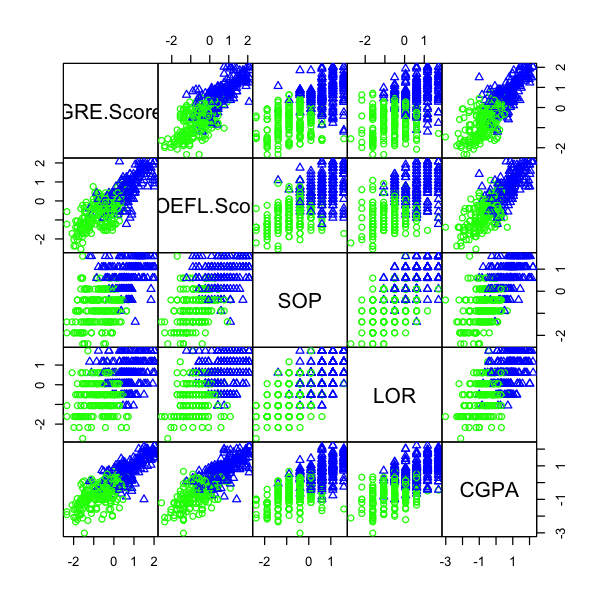

In [15]:
cl=km.res$cluster
pairs(df_sc,gap=0,pch=cl,col=c('green','blue')[cl])

__Gre.Score,TOEFL.Score,GCPA are able to clusterize our data instead LOR and SOP are not able__

__Visualizing K-means clusters in the first 2 PCs space__

The function fviz_cluster() [factoextra package] can be used to easily visualize k-means clusters in the space spanned by the first two PCs. It takes k-means results and the original data as arguments. In the resulting plot, observations are represented by points and It’s also possible to draw concentration ellipse around each cluster.

Warning message:
“ggrepel: 198 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


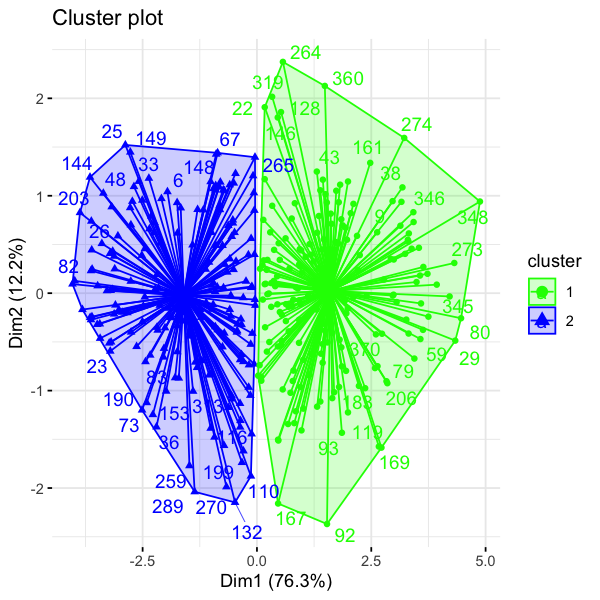

In [16]:
fviz_cluster(list(data=df_sc,cluster=cl),
             palette=c('green','blue'),
             ellipse.type='convex',
             star.plot=TRUE,
             repel=TRUE,
             how.clust.cent = FALSE,
             ggtheme = theme_minimal())

If we use 'convex' as ellipse type, we can say that in The space spanned by the first two Pcs the cluster's structure is preserved and in this new space there is not overlap between the two clusters.

__Internal cluster Validation__

* __silhouette method__
* __Dunn index__

  cluster size ave.sil.width
1       1  200          0.39
2       2  200          0.41


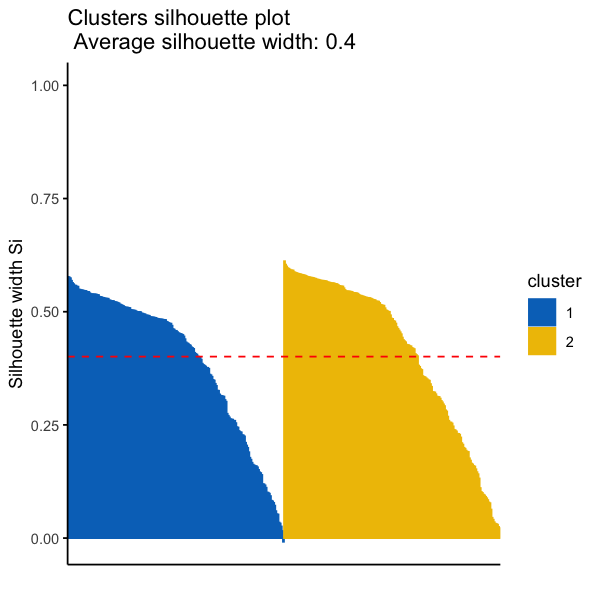

In [17]:
sil = silhouette(km.res$cluster,dist(df_sc))
fviz_silhouette(sil.obj = sil, palette='jco',ggtheme = theme_classic())

In [18]:
neg_sil_index = which(sil[, "sil_width"] < 0)

In [20]:
C=cbind(df[neg_sil_index,],admitted[neg_sil_index])
colnames(C) = c('GRE.Score','TOEFL.Score','SOP','LOR','CGPA','Admitted')
View(C)
View(df_sc[neg_sil_index,])


GRE.Score TOEFL.Score SOP LOR CGPA Admitted
365 313       102         3.5 4   8.9  TRUE

GRE.Score TOEFL.Score         SOP         LOR        CGPA 
-0.33184743 -0.89133993  0.09931782  0.60936414  0.50489077

According to Silhouette width the partition obtained by k-means has an Avarege Silhouette width of 0.4 and only one unit has a negative value, so for that unit it is better to be assigned to the nearest cluster instead of in your own. 

In [107]:
kmeans_stats = cluster.stats(dist(df_sc), km.res$cluster)
kmeans_stats$dunn   #dunn index
kmeans_stats$min.separation    # inter-cluster separation
kmeans_stats$max.diameter   # intra-cluster compactness

[1] 0.06627524

[1] 0.3662989

[1] 5.526933

Dunn Index value is low, around 0.07. It is due to a maximum diameter of the clusters of 5.5, which is greater than the minimum distance between the clusters of 0.37. Therefore, the data might not contain very compact and well-separated clusters.

### K-MEDOIDS
Another partitioning clustering process is reported, as perfomed with K-medoids algorithm using R pam() function. The K-medoids clustering method, despite being a robust alternative to K-means due to its less sensitiveness to noise and outliers. Each cluster is represented by one of the points in the cluster (Medoid) and it's possible to use this algoritm also when we have categorical variables, but in this case we have to compute the dissimilarity matrix.

In [80]:
set.seed(123)
pam.res = pam(df_sc,2,n=200)

#informations
pam.res$clusinfo
pam.res$id.med
pam.res$medoids

size max_diss av_diss  diameter separation
[1,] 201  2.626699 1.444420 4.773020 0.2742936 
[2,] 199  3.464514 1.516049 5.526933 0.2742936

[1] 308 316

GRE.Score  TOEFL.Score SOP        LOR        CGPA      
[1,]  0.7140276  0.7562385   0.5959069  0.6093641  0.6725868
[2,] -0.7676287 -0.5618242  -0.8938604 -0.5036297 -0.8869861

above there is the table that contains the value of the two medoids for each variable.

In [86]:
aggregate(df,by=list(cluster=pam.res$clustering),mean)

cluster GRE.Score TOEFL.Score SOP      LOR      CGPA    
1 1       325.2289  111.6318    4.124378 4.042289 9.046965
2 2       308.3015  103.1457    2.668342 2.856784 8.146382

In [87]:
aggregate(df_sc,by=list(cluster=pam.res$clustering),mean)

cluster GRE.Score  TOEFL.Score SOP        LOR        CGPA      
1 1        0.7339738  0.6955814   0.7194366  0.6564310  0.7513455
2 2       -0.7413504 -0.7025722  -0.7266671 -0.6630283 -0.7588967

__Visualizing PAM clusters in the original space__

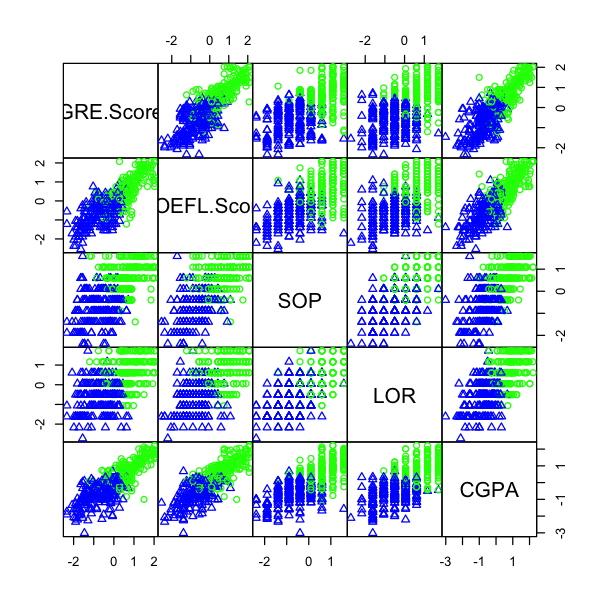

In [88]:
cl2= pam.res$clustering
pairs(df_sc,gap=0,pch=cl2,col=c('green','blue')[cl2])

__Gre.Score,TOEFL.Score,GCPA are able to clusterize our data instead LOR ans SOP are not able__

__Visualizing PAM clusters in the first 2 PCs space__

Warning message:
“ggrepel: 198 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


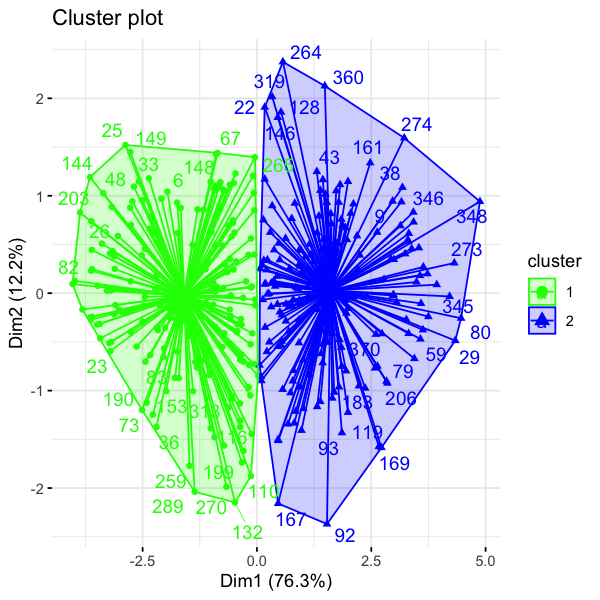

In [115]:
fviz_cluster(list(data=df_sc,cluster=cl2),
             palette=c('green','blue'),
             ellipse.type='convex',
             star.plot=TRUE,
             repel=TRUE,
             how.clust.cent = FALSE,
             ggtheme = theme_minimal())

If we use 'convex' as ellipse type, we can say that in The space spanned by the first two Pcs the cluster's structure is preserved and in this new space there is not overlap between the two clusters.

__Internal cluster Validation__

* __silhouette method__
* __Dunn index__

  cluster size ave.sil.width
1       1  201          0.41
2       2  199          0.39


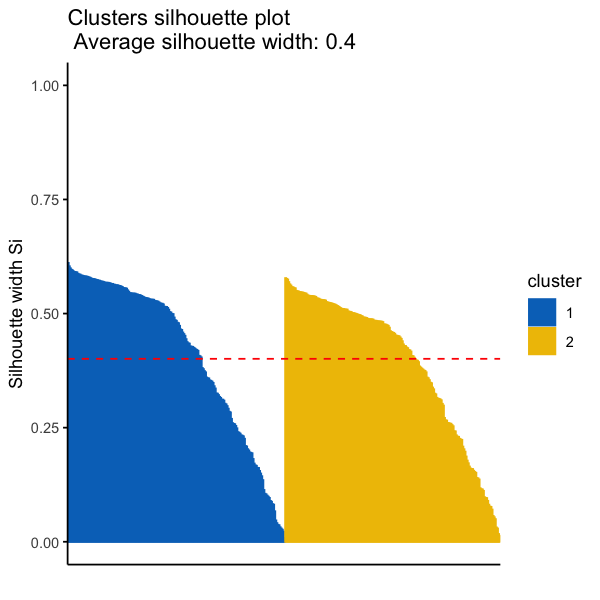

In [116]:
# Internal cluster validation
sil2 = silhouette(pam.res$cluster,dist(df_sc))
fviz_silhouette(sil.obj = sil2, palette='jco',ggtheme = theme_classic())

With K-medoids that the missclassification obtained when we used Kmeans is not present.
In ours case K-medoid seems to be usefull to classify better the units in the two partitions __because this method is more robust to the presence of outliers respect to K-means__.

In [117]:
pam_stats = cluster.stats(dist(df_sc), pam.res$cluster)
pam_stats$dunn    # Dunn index

pam_stats$min.separation    # inter-cluster separation
pam_stats$max.diameter      # intra-cluster compactness

[1] 0.04962853

[1] 0.2742936

[1] 5.526933

Dunn Index value is low, around 0.05. It is due to a maximum diameter of the clusters of 5.5, which is greater than the minimum distance between the clusters of 0.27. Therefore, the data might not contain very compact and well-separated clusters. Since that Dunn Index must be maximized this situation is a little bit worst respect the case of case K-means

### HIERACHICAL CLUSTERING
Hierarchical clustering tries to build a hierarchy of clusters and displayes it as a tree diagram called dendrogram: by cutting the dendrogram at a certain level of dissimilarity we obtain a partition of units into different clusters.
Hierarchical clustering methods do not require the number of clusters K as an input

__AVERAGE linkage criterion__

In [82]:
hc_fit = hclust(dist(df_sc,method='manhattan'), method = 'average')
clust= cutree(hc_fit,k=2)

Warning message in data.frame(xmin = unlist(xleft), ymin = unlist(ybottom), xmax = unlist(xright), :
“row.names ricavati da una variabile con pochi elementi e quindi non utlizzabili”


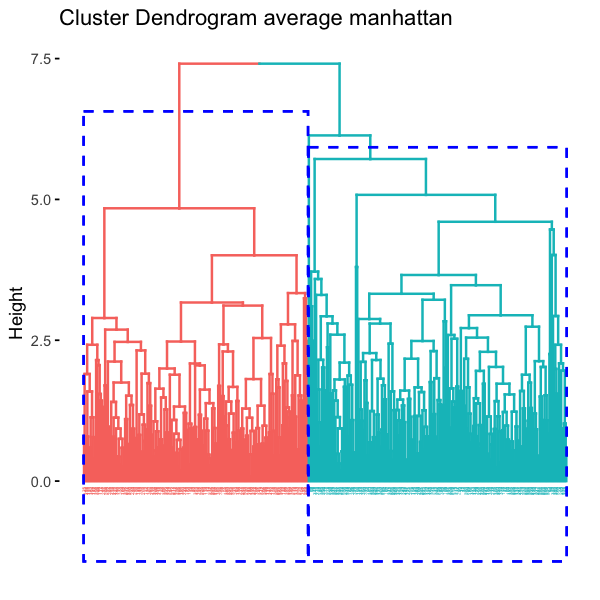

In [24]:
fviz_dend(hc_fit,cex=0.2,k=2,color_labels_by_k = TRUE,
                    rect = TRUE,rect_border='blue',
                    main = paste("Cluster Dendrogram",'average','manhattan'))

  cluster size ave.sil.width
1       1  186          0.44
2       2  214          0.40


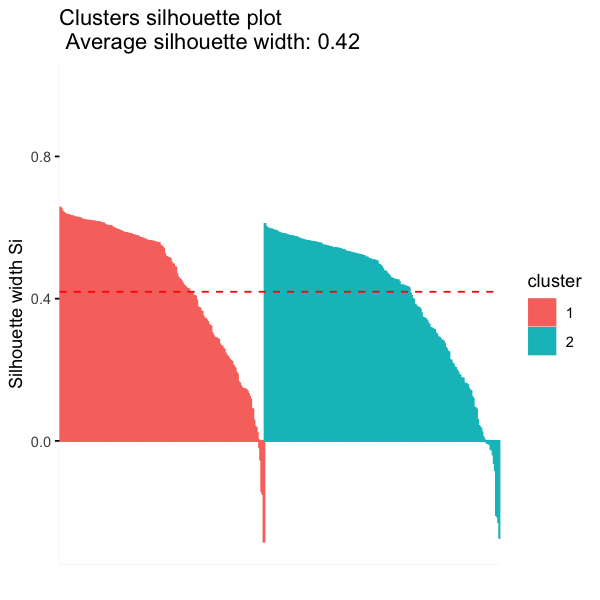

In [25]:
fviz_silhouette(silhouette(clust,dist(df_sc,method='manhattan'),palette='jco',ggtheme = theme_classic()))

According to Silhouette width the partition obtained has an Average Silhouette width of 0.42. 
There are few units which belong to the first cluster and few units  which belong to the second cluster with a negative value of Silhouette width, so for that units it is better to be assigned to the nearest cluster instead of in your own.


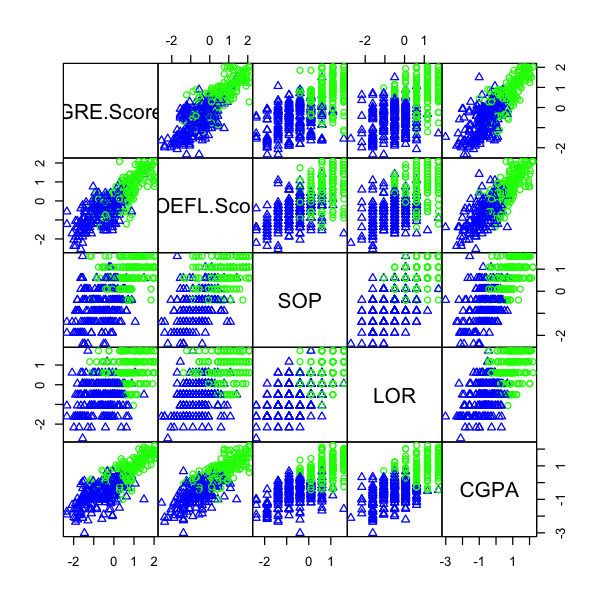

In [21]:
pairs(df_sc,gap=0,pch=clust,col=c('green','blue')[clust])

__Gre.Score,TOEFL.Score,GCPA are able to clusterize our data instead LOR and SOP are not able.__



In [26]:
aggregate(df,by=list(cluster=clust),mean)

cluster GRE.Score TOEFL.Score SOP      LOR      CGPA    
1 1       325.4301  111.7473    4.161290 4.123656 9.082366
2 2       309.3131  103.6402    2.738318 2.869159 8.178738

In [27]:
aggregate(df_sc,by=list(cluster=clust),mean)

cluster GRE.Score  TOEFL.Score SOP        LOR        CGPA      
1 1        0.7515142  0.7146061   0.7560970  0.7469924  0.8107106
2 2       -0.6531852 -0.6211063  -0.6571684 -0.6492551 -0.7046363

__we can see that:__ 
* __in the first cluster there are people that have grades above the mean for each score__
* __in the second cluster there are people that have grades under the mean for each score__


Warning message:
“ggrepel: 198 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


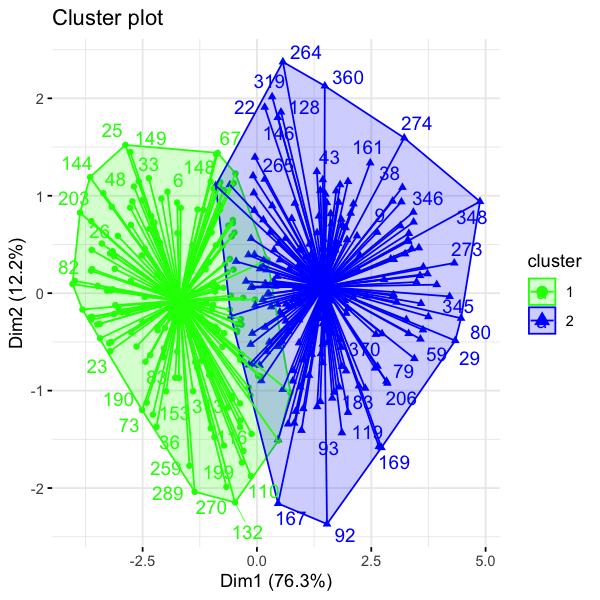

In [68]:
fviz_cluster(list(data=df_sc,cluster=clust),
             palette=c('green','blue'),
             ellipse.type='convex',
             star.plot=TRUE,
             repel=TRUE,
             how.clust.cent = FALSE,
             ggtheme = theme_minimal())

__SINGLE linkage criteion__

In [41]:
hc_fit = hclust(dist(df_sc,method='manhattan'), method = 'single')
clust= cutree(hc_fit,k=2)

Warning message in data.frame(xmin = unlist(xleft), ymin = unlist(ybottom), xmax = unlist(xright), :
“row.names ricavati da una variabile con pochi elementi e quindi non utlizzabili”


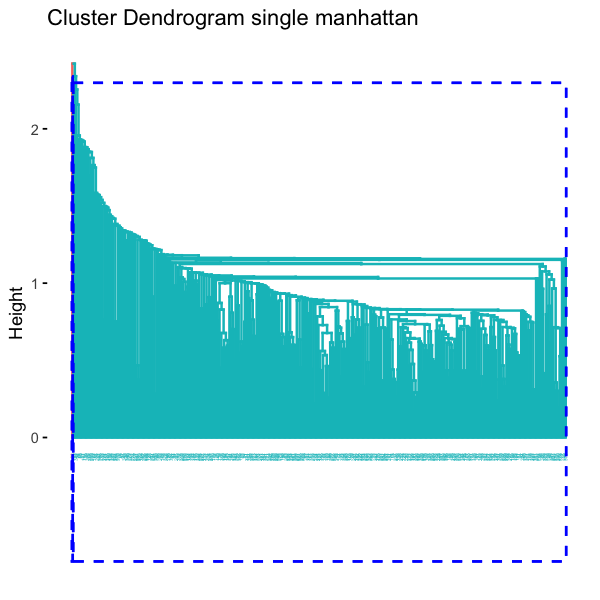

In [42]:
fviz_dend(hc_fit,cex=0.2,k=2,color_labels_by_k = TRUE,
                    rect = TRUE,rect_border='blue',
                    main = paste("Cluster Dendrogram",'single','manhattan'))

  cluster size ave.sil.width
1       1  399          0.19
2       2    1          0.00


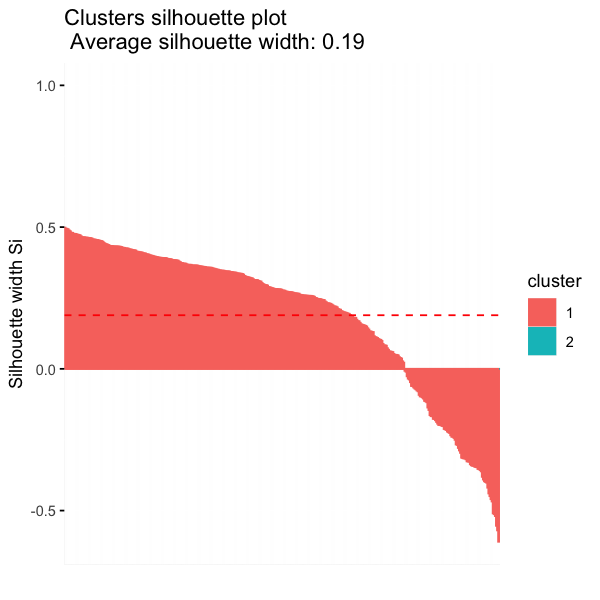

In [43]:
fviz_silhouette(silhouette(clust,dist(df_sc,method='manhattan'),palette='jco',ggtheme = theme_classic()))

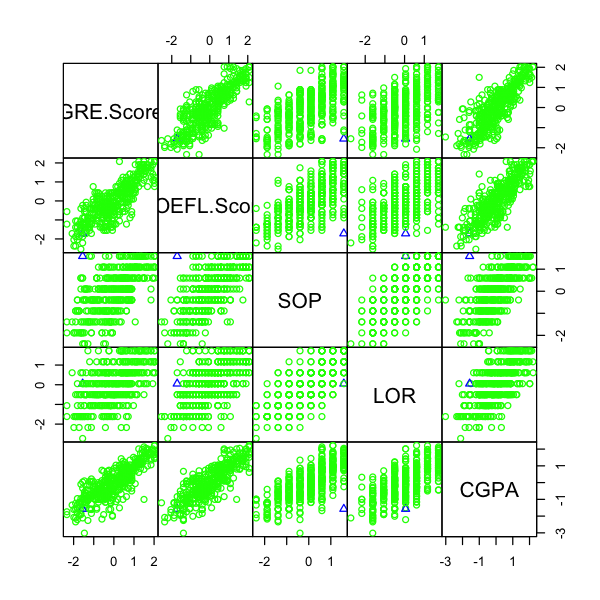

In [44]:
pairs(df_sc,gap=0,pch=clust,col=c('green','blue')[clust])

__It’ interesting observe only the outlier present in our data, which is a person which has grades far below the mean for all the variables except for SOP and LOR. Infact looking at the jointly plot between SOP and LOR we can see that the blue dot is in high position of SOP and in the middle position of LOR. It’s a guy which has a medium reference letter and a high motivation.__

In [45]:
aggregate(df,by=list(cluster=clust),mean)

cluster GRE.Score TOEFL.Score SOP     LOR      CGPA    
1 1       316.8521  107.4361    3.39599 3.452381 8.601278
2 2       299.0000   97.0000    5.00000 3.500000 7.660000

In [46]:
aggregate(df_sc,by=list(cluster=clust),mean)

cluster GRE.Score    TOEFL.Score  SOP         LOR           CGPA        
1 1        0.003889812  0.004298569 -0.00398267 -0.0001324993  0.003946215
2 2       -1.552034970 -1.715129149  1.58908514  0.0528672086 -1.574539797

__we can see that:__
* __in the first cluster there are people that have grades equal to the mean for each score__
* __in the second cluster there is only a person which has grades far below the mean for all the variables, except for SOP and Lor for which has respectively a grade far above the mean and a grade equal to the mean.__

Warning message:
“ggrepel: 198 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


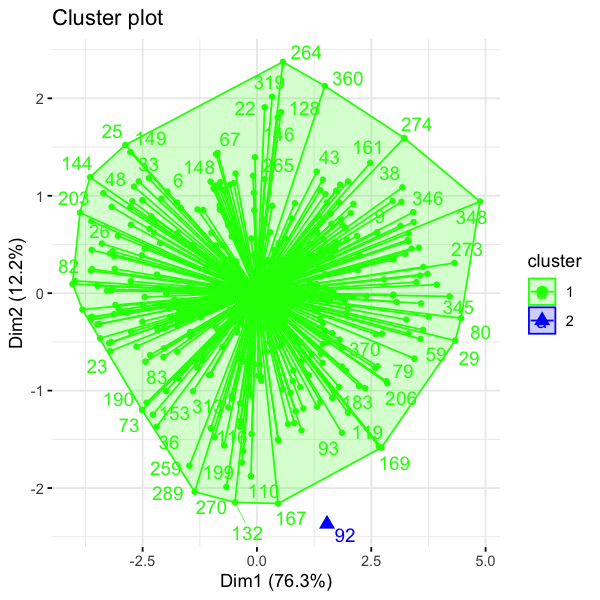

In [47]:
fviz_cluster(list(data=df_sc,cluster=clust),
             palette=c('green','blue'),
             ellipse.type='convex',
             star.plot=TRUE,
             repel=TRUE,
             how.clust.cent = FALSE,
             ggtheme = theme_minimal())

Also in the space spanned by the first two POcs we can oserve that the second cluster is an outlier.

In [40]:
C=cbind(df[92,],admitted[92])
colnames(C) = c('GRE.Score','TOEFL.Score','SOP','LOR','CGPA','Admitted')
C

GRE.Score TOEFL.Score SOP LOR CGPA Admitted
92 299       97          5   3.5 7.66 FALSE

#### __Now let's try if adding the dummy variable 'Research' into clusterizzation process brings to a better result.__

We will compare the result obtained before(without 'Reasearch') with the new result which we are going to compute, only basing on AVG.SIL.WIDTH and DUNN INDEX
* first of all we have to compute the dissimilarity matrix thanks the __Gower Index__!

In [50]:
gower_mat= daisy(DF, metric = c("gower"))

__SILHOUETTE and DUNN INDEX METHOD k-Medoids__

In [12]:
pam_fit = pam(gower_mat, diss = TRUE,n=200 ,k = 2)
sil = silhouette(pam_fit$clustering,dist(df_sc))
sil_width = mean(sil[,3])
sil_width

dunn=cluster.stats(dist(df_sc),clustering=pam_fit$clustering)$dunn 
dunn

[1] 0.2767255

[1] 0.02461438

We can observe that both 'Avg.Sil.Width' and 'Dunn Index' are worse than the case where we don't add the dummy 'Research' in the clusterizzation process. 
Infact before Avg.Sil.Width and Dunn Index were rispectively 0.4 and 0.049

__SILHOUETTE and DUNN INDEX METHOD HC__

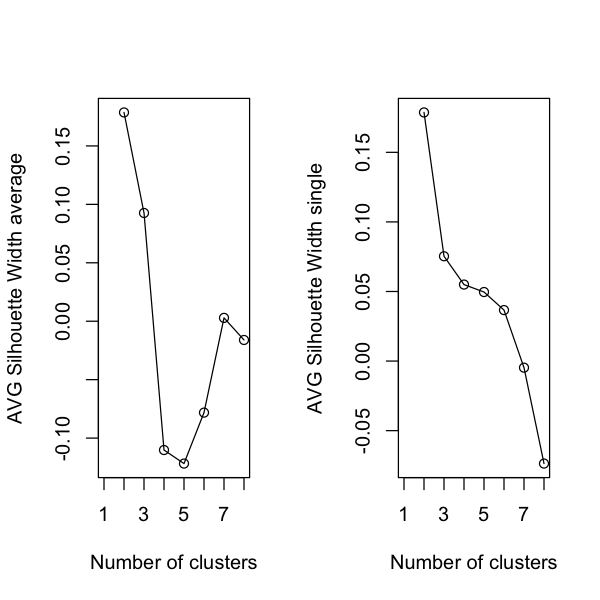

In [17]:
par(mfrow=c(1,2)) 
sil_width_AVG = c(NA)
methods =c('average','single')
for (m in methods){
    hc_fit = hclust(gower_mat, method = m)     
    for(i in 2:8){
        clust= cutree(hc_fit,k=i)
        sil_width_AVG[i] = mean(silhouette(clust,dist(df_sc))[,3])
    }     
plot(1:8, sil_width_AVG,xlab = "Number of clusters",
ylab = paste("AVG Silhouette Width",m))
lines(1:8, sil_width_AVG)
}


We can see that the Avg.sil.Width is maximized in correspondace of K=2 but the values on it for both he the linkage criterion are very low.

In [16]:
methods =c('average','single') 
v=c()
for (m in methods){
    hc_fit = hclust(gower_mat, method = m)             
    clust= cutree(hc_fit,k=2)
    dunn = cluster.stats(dist(df_sc),clustering=clust)$dunn
    v=cbind(v,dunn)
    }
show(v)

           dunn       dunn
[1,] 0.02113278 0.02113278


We can see that the Dunn index  in correspondace of K=2 is lower than the previusly case when 'Research' varibale is not added in the clusterizzation process.

__Let's show the reader how we lose the cluster's structure.__

In [51]:
hc_fit = hclust(gower_mat, method = 'average')
clust= cutree(hc_fit,k=2)

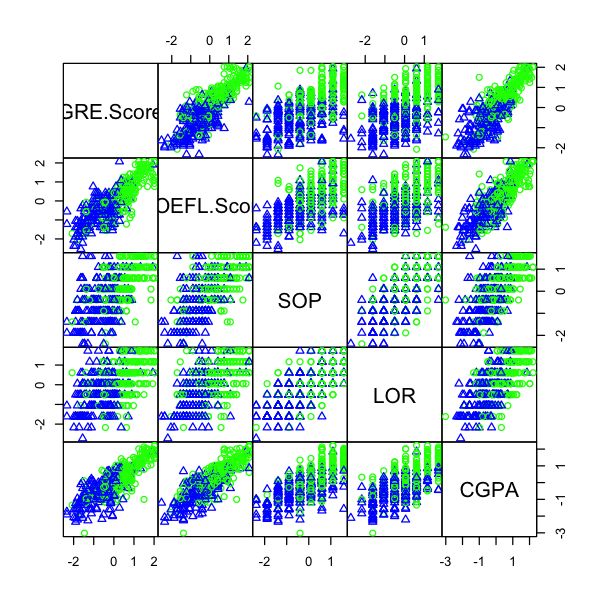

In [52]:
pairs(df_sc,gap=0,pch=clust,col=c('green','blue')[clust])

Warning message:
“ggrepel: 198 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


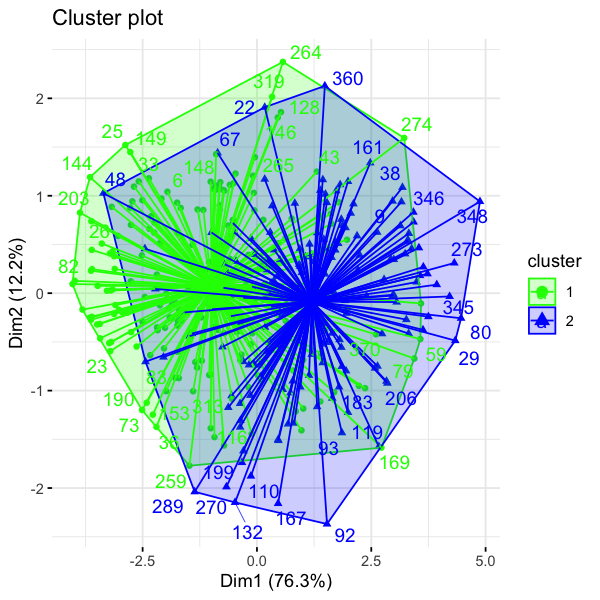

In [55]:
fviz_cluster(list(data=df_sc,cluster=clust), palette=c('green','blue'),
ellipse.type='convex',star.plot=TRUE,repel=TRUE,how.clust.cent = FALSE,
ggtheme = theme_minimal())


__So we can conclude that Adding 'Research' variable is not useful because we lose the cluster structure!
Infact we obtain lower values of AVG.Sil.Width and Dunn Index both on K-medois and HC!
So probably it means that the impact of this variable on the Process of Admission dosen't play a fondamental role__

### External cluster validation

which consists in comparing the results of a cluster analysis to an externally known result, such as externally provided class labels. Since that sometimes we know the “true” cluster number in advance, this approach is mainly used for selecting the right clustering algorithm for a specific data set. We will use:

* __Adjust Rand Index__ which measures the 'Agreement' between the “true” clusters and the cluster solution. It assumes value between [-1,+1] and must be maximize
* __Meila’s VI__ which measures the 'Disagreement' between the “true” clusters and the cluster solution. It must be Minimize

__HIERARCHICAL CLUSTERING__

In [17]:
AdjRIx=c()
Vi=c()
methods =c('average','single')
for (m in methods){
  hc_fit = hclust(dist(df_sc), method = m)
  clust= cutree(hc_fit,k=2)
  AdjRIx = c(AdjRIx,adj.rand.index(as.numeric(admitted),clust))
  Vi=c(Vi,cqcluster.stats(dist(df_sc),clust,alt.clustering=as.numeric(admitted))$vi)
}

In [20]:
G=matrix(c(AdjRIx,Vi),ncol=2, nrow=2,byrow =TRUE)
colnames(G)=methods
View(G)

average   single       
[1,] 0.4957744 -0.0004306241
[2,] 1.0888874  0.7140948274

* Thanks to the AdjRand index, if we compare the partitions obtained by each linkage criterion  with the 'Admitted' partition, we can conclude that the 'AVERAGE' criterion is the winner because it Maximize the index reaching the value of 0.5, so it means that there is a good 'Agreement'.

* Thanks to the Meila's VI index, if we compare the partitions obtained by each linkage criterion  with the 'Admitted' partition, we can conclude that the 'SINGLE' criterion is the winner because it Minimize the index reaching the value around of 0.71.

__K-MEDOIDS__

In [26]:
AdjRIx = adj.rand.index(admitted,pam.res$clustering)
Vi=cqcluster.stats(dist(df_sc),pam.res$clustering,alt.clustering=as.numeric(admitted))$vi

AdjRIx
Vi

[1] 0.5464656

[1] 1.075348

* Thanks to the AdjRand index, if we compare the partitions obtained by PAM algorithm with  'Admitted' partition, we obtain a value of 0.55, so it means that there is a good 'Agreement'.

* Thanks to the Meila's VI index, if we compare the partitions obtained by PAM algorithm  with 'Admitted' partition, we obtain a value of 1.07.

__K-MEANS__

In [31]:
AdjRIx = adj.rand.index(admitted,km.res$cluster)
Vi=cqcluster.stats(dist(df_sc),km.res$cluster,alt.clustering=as.numeric(admitted))$vi

AdjRIx
Vi

[1] 0.5390721

[1] 1.085666

* Thanks to the AdjRand index, if we compare the partitions obtained by K-MEANS algorithm with 'Admitted' partition, we obtain a value of 0.54, so it means that there is a good 'Agreement'.

* Thanks to the Meila's VI index, if we compare the partitions obtained by PAM algorithm  with 'Admitted' partition, we obtain a value of 1.08.

__To summarize the best algorith according to the External Cluster validation seems to be the K-medoid__

### MODEL BASED CLUSTERING

In [56]:
#Fit the parsimonious models
model = Mclust(df_sc, G = 1:6, modelNames = NULL)

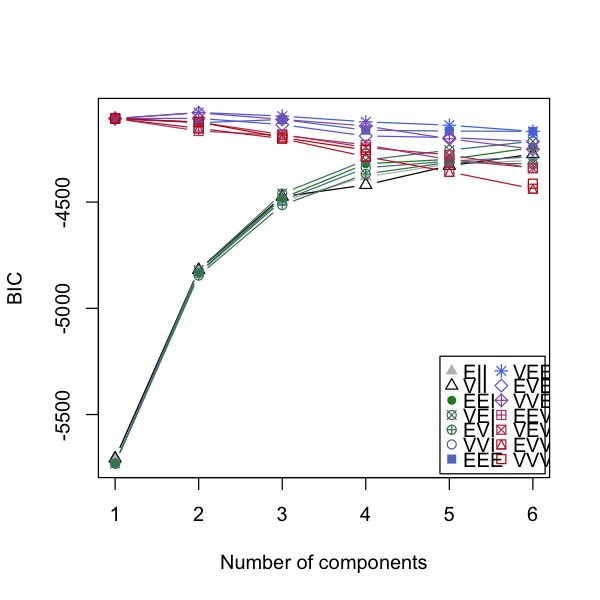

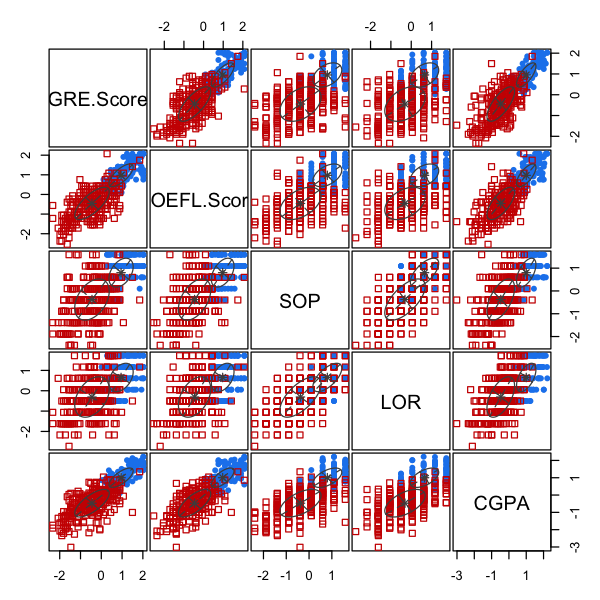

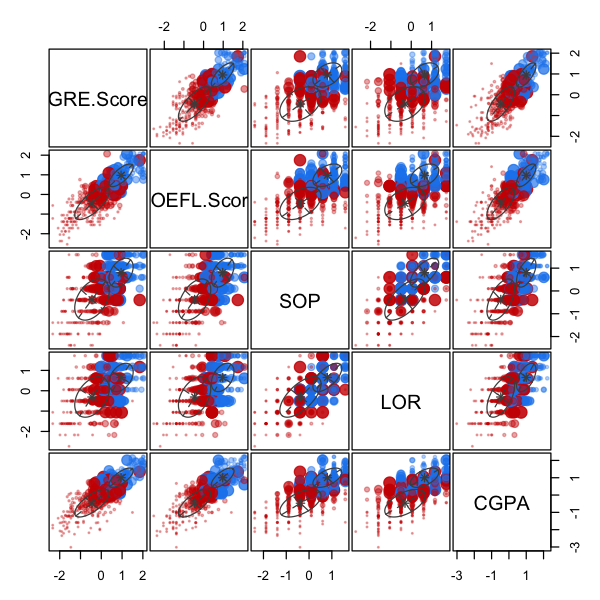

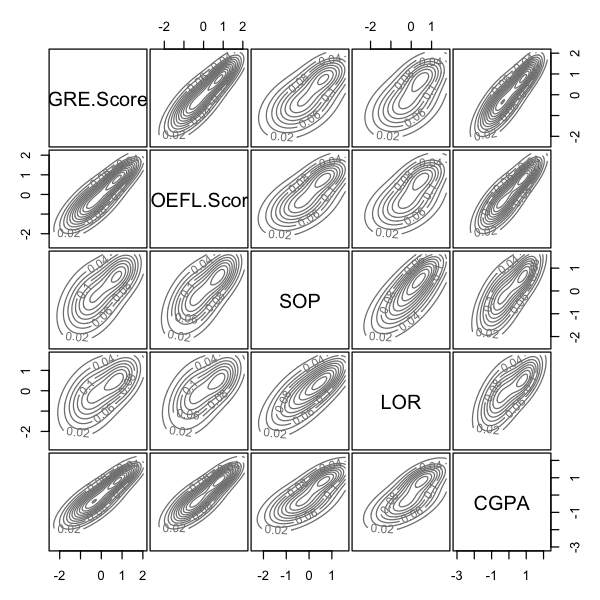

In [57]:
#Plot of the BIC values for all the fitted models
plot(model)

The best clustering models according to the __BIC__ are:

In [58]:
summary(model$BIC)

Best BIC values:
             VEE,2        VVE,2       VEE,3
BIC      -4078.216 -4079.935902 -4095.33458
BIC diff     0.000    -1.719493   -17.11817

We can see that the best parsimonious model obtained is __VEE with three cluster, because it maximizes the BIC!__


Warning message:
“`gather_()` was deprecated in tidyr 1.2.0.
ℹ Please use `gather()` instead.
ℹ The deprecated feature was likely used in the factoextra package.
  Please report the issue at <https://github.com/kassambara/factoextra/issues>.”


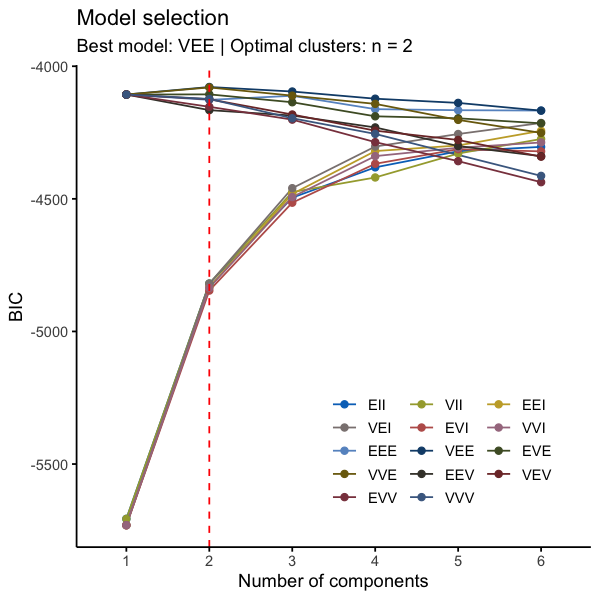

In [59]:
# BIC values used for choosing the number of clusters
fviz_mclust(model, "BIC", palette = "jco")

We can also see the matrix of __Soft Assignement__

In [60]:
head(round(model$z,6),5)  # Probability to belong to a given cluster

[,1]     [,2]    
[1,] 0.987312 0.012688
[2,] 0.325303 0.674697
[3,] 0.002446 0.997554
[4,] 0.424155 0.575845
[5,] 0.002787 0.997213

__Visualize the data in the Original Space__

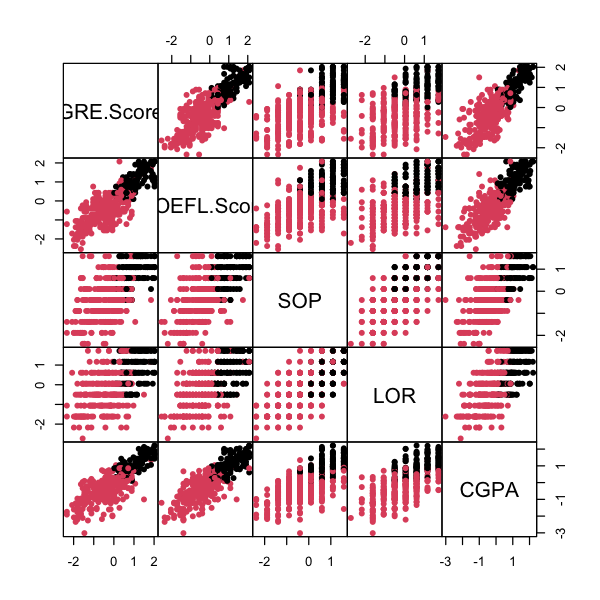

In [61]:
# pairs plot with classification
pairs(df_sc,gap=0,pch=16,col=model$classification)

__Gre.Score,TOEFL.Score,GCPA are able to clusterize our data instead LOR and SOP are not able__

__Visualizing the obtained results in the PC space__

Warning message:
“ggrepel: 205 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


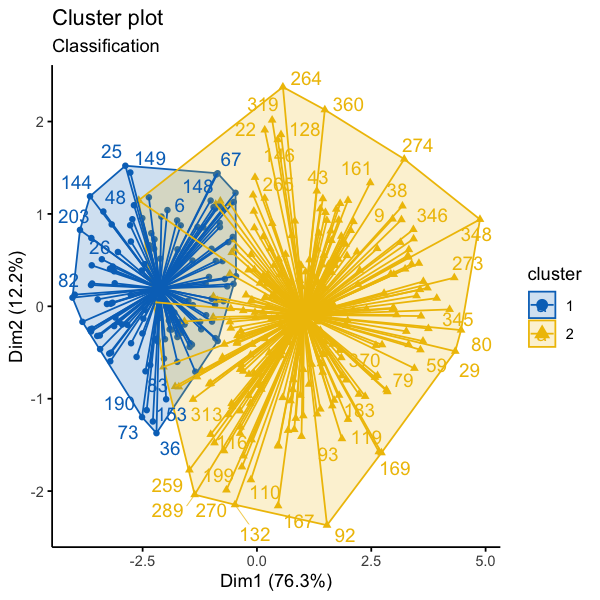

In [62]:
fviz_mclust(model, "classification", palette = "jco",
           ellipse.type='convex',
                   star.plot=TRUE,
                   repel=TRUE,
                   how.clust.cent = FALSE,
                   ggtheme = theme_minimal())

If we use 'convex' as ellipse type, we can say that in The space spanned by the first two Pcs the clsuster structure is not enought preserved because and in this new space there is a big overlap between the two clusters.

__Visualizing the Uncertainty Classification in the PCs space__

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as
of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the factoextra package.
  Please report the issue at <https://github.com/kassambara/factoextra/issues>.”


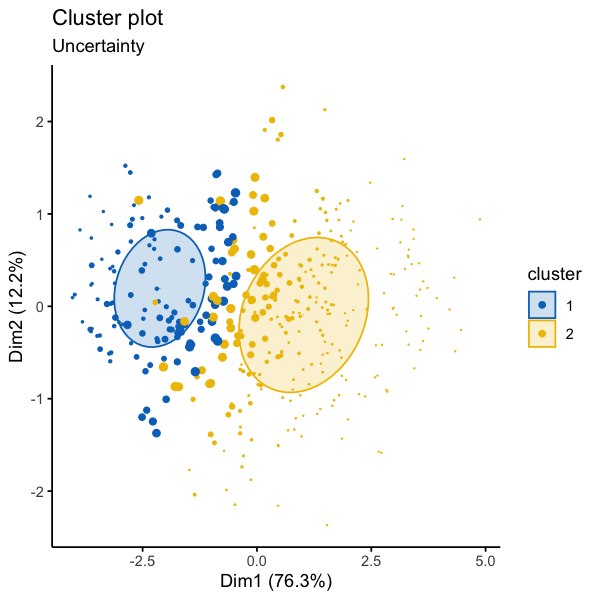

In [43]:
fviz_mclust(model, "uncertainty", palette = "jco")

All the points blue and yellow in the middle are point where the classification it is difficult, and the bigger the points the more difficult is the classification.

__External Cluster Validation__

In [42]:
# Adjusted Rand Index and Vi index
adjustedRandIndex(admitted, model$classification)
Vi=cqcluster.stats(dist(df_sc),model$classification,alt.clustering=as.numeric(admitted))$vi
Vi

[1] 0.4017636

[1] 1.095565

* Thanks to the AdjRand index, we obtain a value of 0.40, so it means that seems to be a certain 'Agreement',but between the model classification's and our partition 'Admitted'

* Thanks to the Meila's VI index, if we compare the model classification's and our partition 'Admitted', we obtain a value of 1.01.

### CLASSIFFICATIONS

__K-MEANS__

In [45]:
table(admitted,km.res$cluster)

        
admitted   1   2
   FALSE 178  31
   TRUE   22 169

__K-MEDOIDS__

In [46]:
table(admitted,pam.res$clustering)

        
admitted   1   2
   FALSE  31 178
   TRUE  170  21

__HIERACHICAL CLUSTERING__

In [84]:
hc_fit = hclust(dist(df_sc,method='manhattan'), method = 'average')
Clust= cutree(hc_fit,k=2)
table(admitted,Clust)

        Clust
admitted   1   2
   FALSE  23 186
   TRUE  163  28

__Model Based Clustering (VEE)__

In [44]:
table(admitted, model$classification)

        
admitted   1   2
   FALSE   6 203
   TRUE  124  67

__To summarize we have this podium:__
* __Hc method average distance used manhattan --> 51 misclassification__
* __k-medoids  --> 52 misclassifications__
* __k-means  --> 53 misclassifications__
* __Model Based Clustering (VEE) --> 73 misclassifications__

## CONCLUSIONS


* Two is the optimal number of clusters in our data, for several reasons:

    * According to Avg.Silhouette width
    * According to Internal Validation 
    * According to External Validation (Admitted)
    * According to Model based Clustering (VEE,2)


* The best algorithm is:
    1. In terms of misclassifications:
        * Hc method with 'Average' as linkage criterion and 'Manhattan distance'
    2. According to avg. Silhouette width:
        * Hc method with 'Average' as linkage criterion and 'Manhattan distance'
    3. According to Internal Validation:
        * K-Means
    4. According to External Validation:
        * K-Medoids  with Adj = 0.55 and Vi= 1.07
        

* Including the dummy variable ‘Research’ in the clusterizzation process is not a good choice because we lose the cluster's structure.

* We discovered one outlier thanks to the single linkage method. It is a student with marks so far below the mean but with high motivation. 

* The scores (__ON AVERAGE__) of students which have the probability to be admitted  greater than the mean:


In [85]:
#K-MEANS
aggregate(df,by=list(cluster=km.res$cluster),mean)[2,]
#K-MEDOIDS
aggregate(df,by=list(cluster=pam.res$clustering),mean)[1,]
#HC AVERAGE
aggregate(df,by=list(cluster=Clust),mean)[1,]
#MODEL BASE CLUSTERING VEE
aggregate(df,by=list(cluster=model$classification),mean)[1,]

cluster GRE.Score TOEFL.Score SOP    LOR    CGPA  
2 2       325.29    111.68      4.1275 4.0425 9.0477

cluster GRE.Score TOEFL.Score SOP      LOR      CGPA    
1 1       325.2289  111.6318    4.124378 4.042289 9.046965

cluster GRE.Score TOEFL.Score SOP     LOR      CGPA    
1 1       325.4301  111.7473    4.16129 4.123656 9.082366

cluster GRE.Score TOEFL.Score SOP      LOR      CGPA    
1 1       328.5462  113.7923    4.273077 4.088462 9.236538